In [100]:
from decimal import Decimal
import json
from decimal import InvalidOperation

objs = []
root = '/Users/rivers/Desktop/nice datasets/MOBA/'
data_root = root+'matches/'
save_root = root+'Topics/Bursty/intermediate/'
graph_root = root+'Topics/Bursty/results/'
game_mode = -1

mode_dict = {-1: 'captainrank', 22: 'rank',1:'allpick',5:'allrandom'}

# Custom JSON decoder function to convert strings back to Decimal
def decimal_decoder(obj):
    for key, value in obj.items():
        if isinstance(value, str):  # Ensure the value is a string
            try:
                # Attempt to convert strings that look like Decimals back to Decimal objects
                obj[key] = Decimal(value)
            except InvalidOperation:
                pass  # Skip conversion if the value cannot be converted to Decimal
    return obj

# Read the list of dictionaries back from the JSON file
with open(data_root+'%s_matches_2000.json'%(mode_dict[game_mode]), 'r') as file:
    objs = json.load(file, object_hook=decimal_decoder)

In [40]:
objs[0]['lobby_type']

0

In [45]:
lobby_types = []
count=0
for obj in objs:
    if obj['lobby_type'] == 7:
        count += 1
    lobby_types.append(obj['lobby_type'])

In [46]:
count

242

(array([ 102., 1656.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         242.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

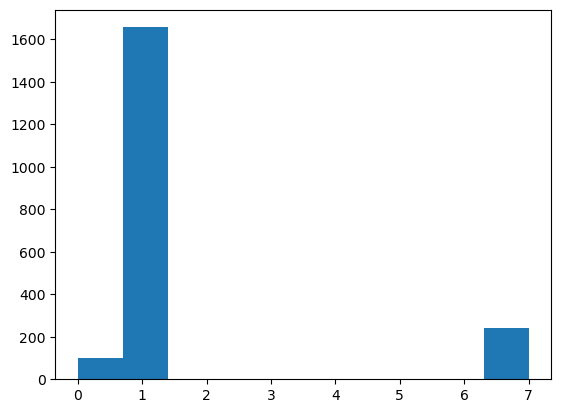

In [47]:
import matplotlib.pyplot as plt
plt.hist(lobby_types)

In [ ]:
def calculate_differences(int_list):
    # Ensure the list has at least 2 elements
    if len(int_list) < 2:
        raise ValueError("The list must contain at least 2 elements.")

    # Calculate the differences between consecutive elements
    differences = [int_list[i+1] - int_list[i] for i in range(len(int_list) - 1)]
    
    return differences

def chats_of(slot,chat):
    t = []
    l = []
    for chat_line in chat:
        #print(chat_line)
        if 'slot' in list(chat_line.keys()):
            if chat_line['slot'] == slot:
                t.append(chat_line['time'])
                l.append(len(str(chat_line['key'])))
    if len(t) > 1:
        t_diff = calculate_differences(t)
        t_diff.insert(0,0)
    
        return l, t_diff
    else:
        return [],[]


In [101]:
# Team 

modes = list(mode_dict.keys())
slots = list(range(10))

team_t, team_l, ind_t, ind_l= {}, {}, {}, {}

for mode in modes:
    with open(data_root+'%s_matches_2000.json'%(mode_dict[mode]), 'r') as file:

        objs = json.load(file, object_hook=decimal_decoder)

        
    team_t_sample, team_l_sample, ind_t_sample, ind_l_sample = [], [], [], []
    for obj in objs:
        if (mode == 2 and obj['lobby_type'] == 7) or mode != 2:
            time = []
            if len(obj['chat']) > 1:
                for chat_line in obj['chat']:
                    time.append(chat_line['time'])
                    
                    team_l_sample.append(len(str(chat_line['key'])))
                
                diff = calculate_differences(time)
                diff.insert(0,0)
                team_t_sample += diff
            
            for slot in slots:
                l, t_diff = chats_of(slot, obj['chat'])
                ind_t_sample += t_diff
                ind_l_sample += l
    
    team_t[mode], team_l[mode], ind_l[mode], ind_t[mode] = team_t_sample, team_l_sample, ind_l_sample, ind_t_sample


In [ ]:
import ijson

objs = []
game_mode = 2
with open(root+'/THAT data/yasp-dump-2015-12-18.json', 'r') as file:
    objects = ijson.items(file, 'item')
    for i, obj in enumerate(objects):
        if obj['game_mode'] == game_mode and obj['lobby_type'] == 7 and len(objs) < 2002:
        # Process each JSON object
            objs.append(obj)
    print(len(objs))
# Custom JSON encoder function
def decimal_default(obj):
    if isinstance(obj, Decimal):
        return str(obj)
    raise TypeError

with open(data_root+'%s_matches_2001.json'%(mode_dict[game_mode]), 'w') as file:
    json.dump(objs, file, default=decimal_default, indent=4)

print('%s_matches_2000.json saved'%(mode_dict[game_mode]))

2002


TypeError: 'int' object is not subscriptable

In [ ]:
with open(data_root+'%s_matches_2001.json'%(mode_dict[game_mode]), 'w') as file:
    json.dump(objs, file, default=decimal_default, indent=4)

print('%s_matches_2000.json saved'%(mode_dict[game_mode]))

TypeError: 'int' object is not subscriptable

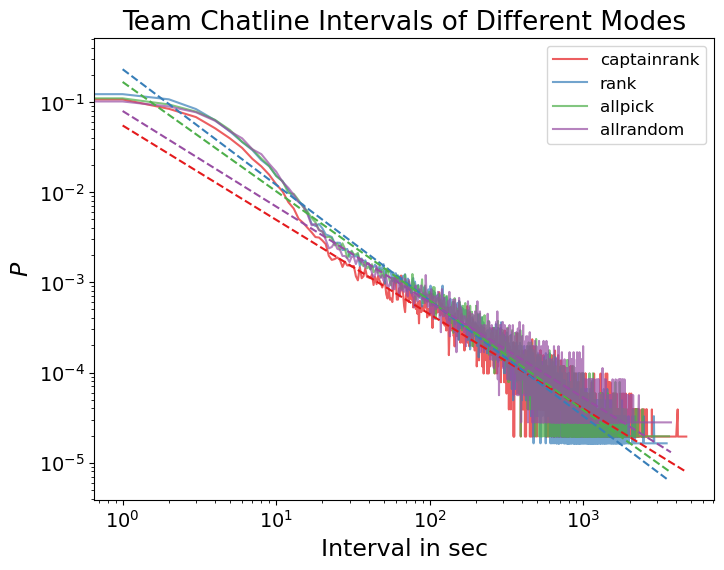

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Define color palette
palette = sns.color_palette("Set1")

# Dictionary to store processed data
ind = {}

# Process each mode's t_sample in ind_t
for i, mode in enumerate(team_t.keys()):  
    dist = Counter(team_t[mode])  # Count occurrences in the current sample
    x, y = [], []
    
    for interval in sorted(dist):   
        x.append(interval)
        y.append(dist[interval] / sum(dist.values()))  # Normalize using total count
    
    ind[mode] = (x, y)  # Store in dictionary

# Plot raw data
plt.figure(figsize=(8, 6))
for i, (mode, (x, y)) in enumerate(ind.items()):
    plt.plot(x, y, label=mode_dict[mode], color=palette[i], alpha=0.7)

# Fit power-law lines
for i, (mode, (x, y)) in enumerate(ind.items()):
    x = np.array(x)
    y = np.array(y)
    
    # Avoid log issues by replacing zeros
    x = np.where(x == 0, 1, x)
    y = np.where(y == 0, 1, y)

    # Fit a power-law in log-log space
    coeffs = np.polyfit(np.log(x), np.log(y), 1)
    fitted_line = np.exp(coeffs[1]) * x ** coeffs[0]

    # Plot fitted line
    plt.plot(x, fitted_line, linestyle='--', color=palette[i])

# Labels, scales, and legend
plt.xlabel('Interval in sec', fontsize=17)
plt.ylabel('$P$', fontsize=17)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Team Chatline Intervals of Different Modes', fontsize=19)
plt.legend(fontsize=12)

# Save and show plot
plt.savefig(graph_root+'team_power_law_fit.pdf')
plt.show()

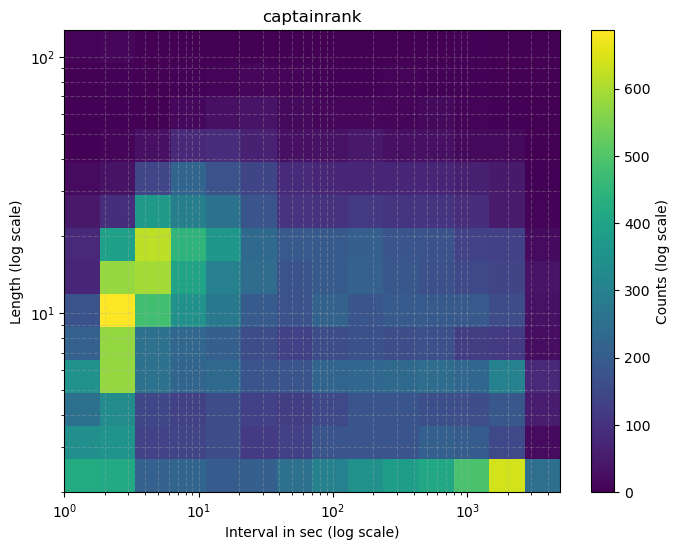

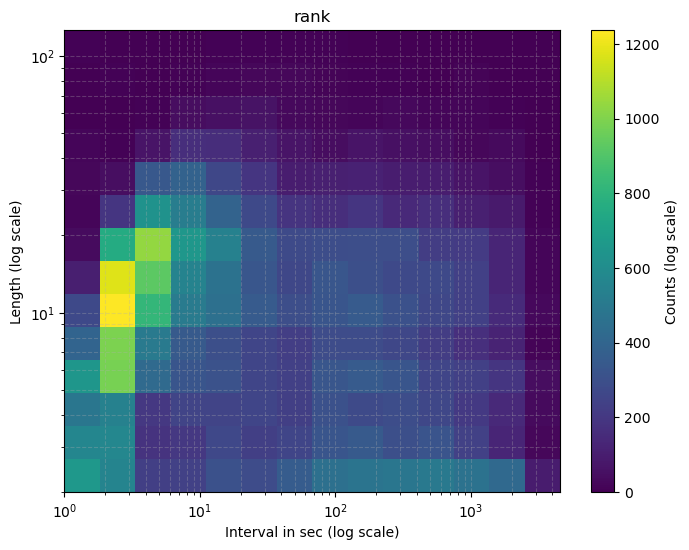

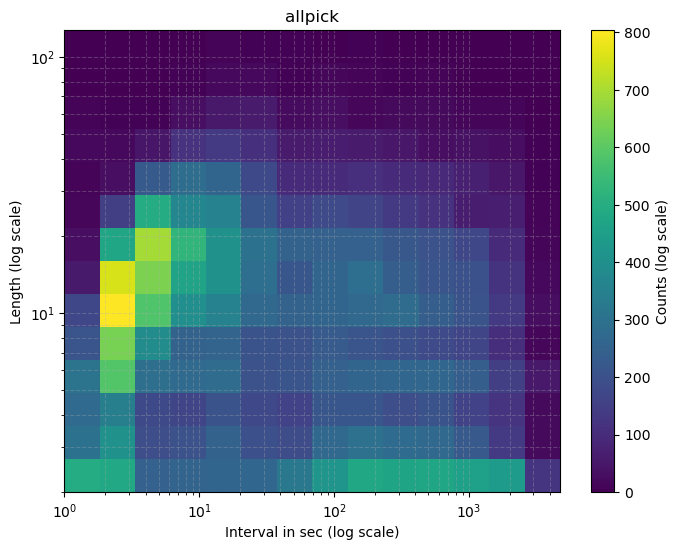

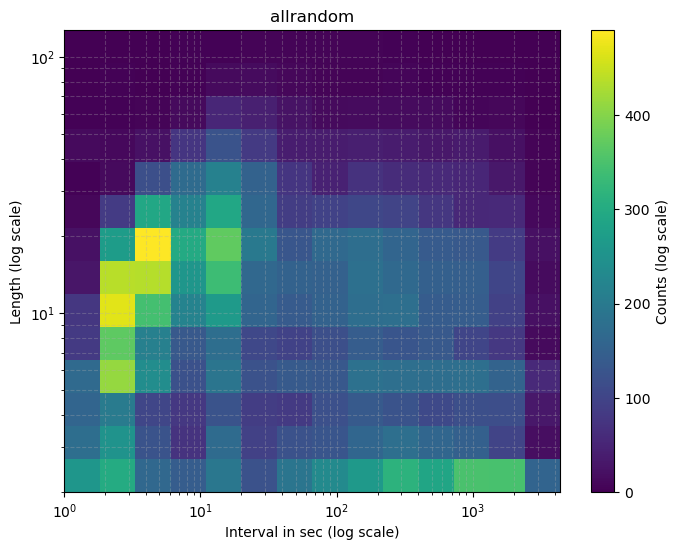

In [116]:
import matplotlib.colors as mcolors
import numpy as np
for mode in modes:

    t_sample = ind_t[mode]
    l_sample = ind_l[mode]
    x_bins = np.logspace(np.log10(min(t_sample) + 1), np.log10(max(t_sample)), 15)
    y_bins = np.logspace(np.log10(min(l_sample) + 1), np.log10(max(l_sample)), 15)

    # Create 2D histogram data
    heatmap, xedges, yedges = np.histogram2d(t_sample, l_sample, bins=[x_bins, y_bins])

    # Plot the heatmap with a logarithmic color scale
    plt.figure(figsize=(8, 6))

    #bounds = np.linspace(0, 1000, 200)
    #norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

    plt.pcolormesh(
        xedges, yedges, heatmap.T, shading='auto', cmap='viridis',
      #  norm=mcolors.LogNorm(vmin=1, vmax=3000)
    )
    plt.colorbar(label='Counts (log scale)')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('Length (log scale)')
    plt.xlabel('Interval in sec (log scale)')
    plt.title(mode_dict[(mode)])
    plt.grid(True, which='both', linestyle='--', alpha=0.3)
    plt.savefig(graph_root+'/heatmap_ind_tVl_%s.pdf'%(mode_dict[mode]))
    plt.show()

2341 2341
2341 2341
2417 2417
2417 2417
2447 2447
2447 2447
2304 2304
2304 2304


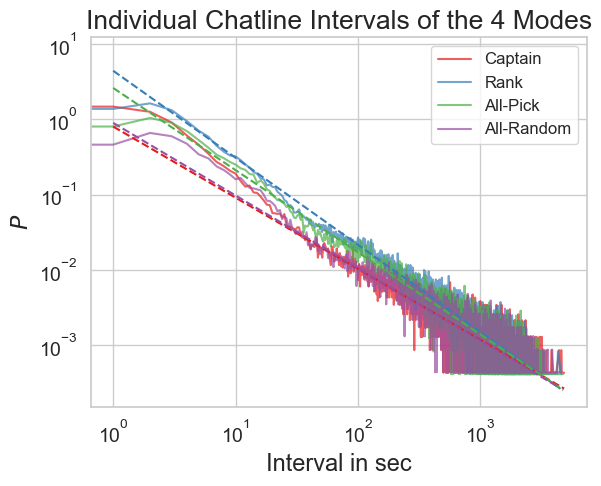

In [187]:
palette = sns.color_palette("Set1")

# Assuming 'rank' contains x1, y1, x2, y2, x3, y3, x4, y4
# Modify colors if needed based on your palette
plt.plot(ind['x1'], ind['y1'], label='Captain', color=palette[0],alpha=0.7)
plt.plot(ind['x2'], ind['y2'], label='Rank', color=palette[1],alpha=0.7)
plt.plot(ind['x3'], ind['y3'], label='All-Pick', color=palette[2],alpha=0.7)
plt.plot(ind['x4'], ind['y4'], label='All-Random', color=palette[3],alpha=0.7)

# Fit lines to each dataset and plot them
for i, (x, y, color) in enumerate([(ind['x1'], ind['y1'], palette[0]), 
                                   (ind['x2'], ind['y2'], palette[1]),
                                   (ind['x3'], ind['y3'], palette[2]),
                                   (ind['x4'], ind['y4'], palette[3])]):
    # Remove zero values to avoid log issues
    x = np.array(x)
    y = np.array(y)
    print(len(x),len(y))
    x = np.where(x == 0, 1, x)
    y = np.where(y == 0, 1, y)
    print(len(x),len(y))
    # Fit line in log-log space
    coeffs = np.polyfit(np.log(x), np.log(y), 1)
    fitted_line = np.exp(coeffs[1]) * x ** coeffs[0]
    
    # Plot fitted line
    plt.plot(x, fitted_line, linestyle='--', color=color,)

# Labels, scales, and legend
plt.xlabel('Interval in sec', fontsize=17)
plt.ylabel('$P$', fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.title('Individual Chatline Intervals of the 4 Modes', fontsize=19)
plt.legend(fontsize=12)

# Save and show plot
plt.savefig('individual power law fit.pdf')
plt.show()

In [48]:
winning_sample = []
losing_sample = []
radiant = [0,1,2,3,4]
dire = [5,6,7,8,9]
count = 0

winning_L = []
losing_L = []



for obj in objs:
    winning_team_t = []
    losing_team_t = []
    wining_diff = []
    losing_diff = []
    w, l = True, True
    if len(obj['chat']) > 1:
        
        for chat in obj['chat']:
            if 'slot' in list(chat.keys()):
                if (chat['slot'] in radiant and obj['radiant_win']==True) or (chat['slot'] in dire and obj['radiant_win']==False):
                    winning_team_t.append(chat['time'])
                    # print('here')
                    if w == False:
                        winning_L.append(len(str(chat['key'])))
                    w = False
                else:
                    losing_team_t.append(chat['time'])
                    if l == False:
                        losing_L.append(len(str(chat['key'])))
                    l = False
                if len(winning_team_t)>1:
                    wining_diff = calculate_differences(winning_team_t)
                if len(losing_team_t)>1:
                    losing_diff = calculate_differences(losing_team_t)
            count+=1
    winning_sample += wining_diff
    losing_sample += losing_diff

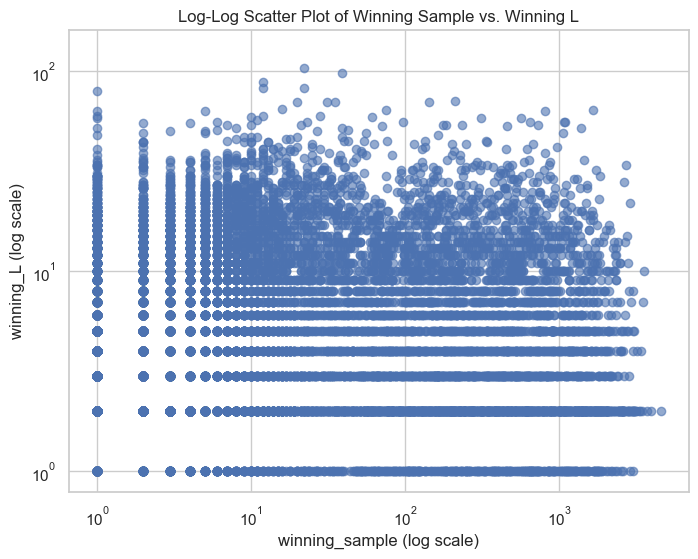

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(winning_sample, winning_L, alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('winning_sample (log scale)')
plt.ylabel('winning_L (log scale)')
plt.title('Log-Log Scatter Plot of Winning Sample vs. Winning L')
plt.grid(True)
plt.show()

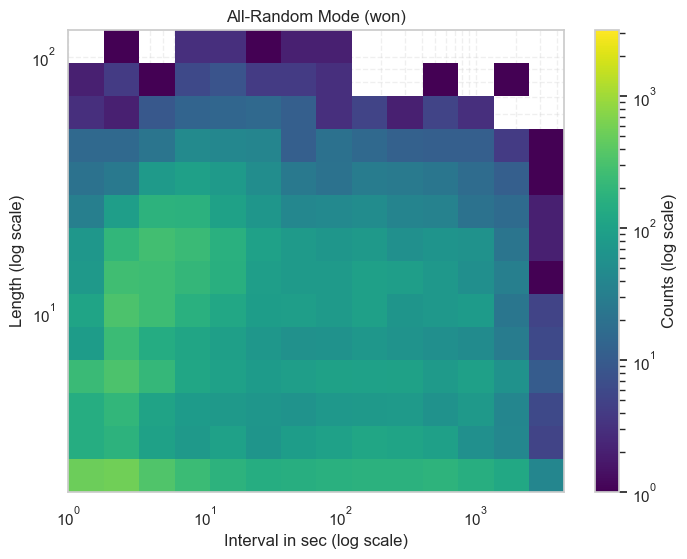

In [119]:
# Create 2D histogram data
# Define logarithmic bins for better granularity in log-log space
import numpy as np
import matplotlib.colors as mcolors

# Define more bins for higher granularity
x_bins = np.logspace(np.log10(min(winning_sample) + 1), np.log10(max(winning_sample)), 15)
y_bins = np.logspace(np.log10(min(winning_L) + 1), np.log10(max(winning_L)), 15)

# Create 2D histogram data
heatmap, xedges, yedges = np.histogram2d(winning_sample, winning_L, bins=[x_bins, y_bins])

# Plot the heatmap with a logarithmic color scale
plt.figure(figsize=(8, 6))
plt.pcolormesh(
    xedges, yedges, heatmap.T, shading='auto', cmap='viridis',
    norm=mcolors.LogNorm(vmin=1, vmax=10**3.5)
)
plt.colorbar(label='Counts (log scale)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Interval in sec (log scale)')
plt.ylabel('Length (log scale)')
plt.title('All-Random Mode (won)')
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.savefig('allrandom won length log.pdf')
plt.show()

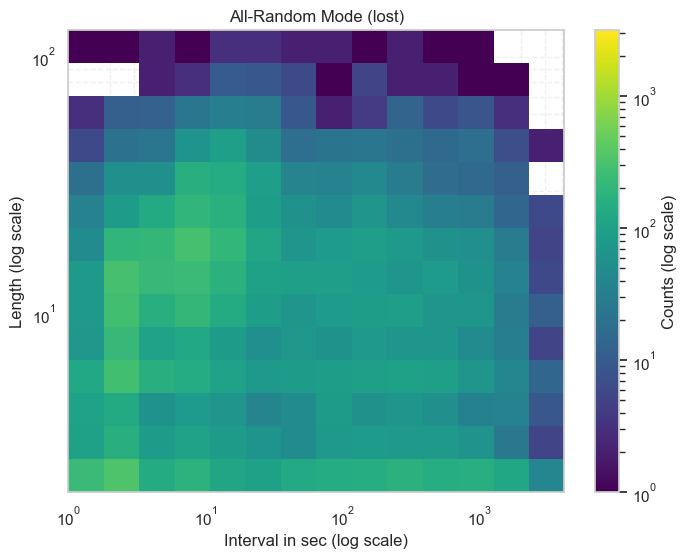

In [120]:
# Define more bins for higher granularity
import matplotlib.colors as colors


x_bins = np.logspace(np.log10(min(losing_sample) + 1), np.log10(max(losing_sample)), 15)
y_bins = np.logspace(np.log10(min(losing_L) + 1), np.log10(max(losing_L)), 15)

# Create 2D histogram data
heatmap, xedges, yedges = np.histogram2d(losing_sample, losing_L, bins=[x_bins, y_bins])

# Plot the heatmap with a logarithmic color scale
plt.figure(figsize=(8, 6))

#bounds = np.linspace(0, 1000, 200)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

plt.pcolormesh(
    xedges, yedges, heatmap.T, shading='auto', cmap='viridis',
    norm=mcolors.LogNorm(vmin=1, vmax=10**3.5)
)
plt.colorbar(label='Counts (log scale)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Length (log scale)')
plt.xlabel('Interval in sec (log scale)')
plt.title('All-Random Mode (lost)')
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.savefig('allrandom lost length log.pdf')
plt.show()

In [7]:
import matplotlib.pyplot as plt

In [12]:
def add_one_to_all(int_list):
    return [x + 1 for x in int_list]

adjusted_intervals = add_one_to_all(interval_sample)


In [38]:
import powerlaw
fit = powerlaw.Fit(adjusted_intervals)

# Perform the KS test
R, p_value = fit.distribution_compare('power_law', 'lognormal')
print(R, p_value)

Calculating best minimal value for power law fit
-1.8894137022793283 0.17460857034742183


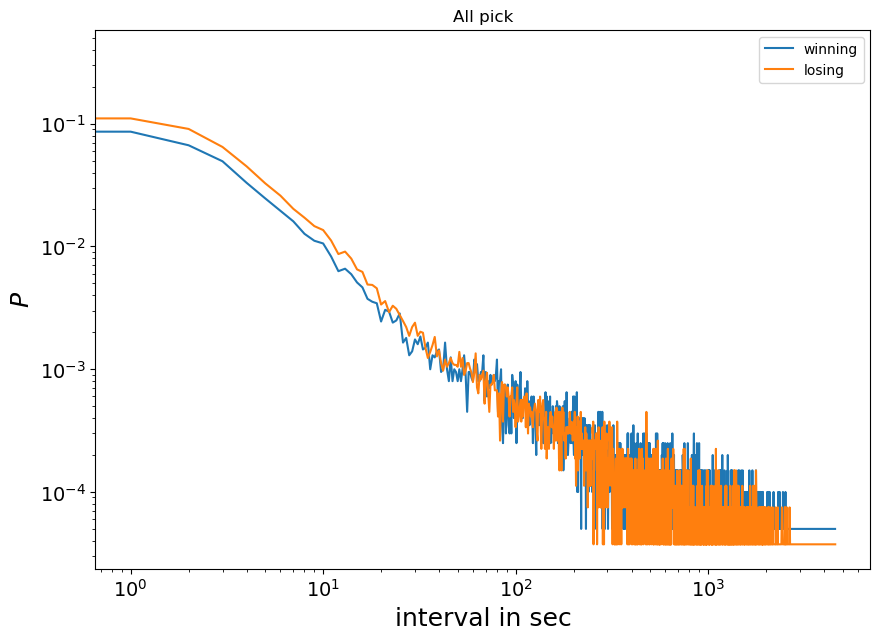

In [52]:
from collections import Counter
wining_dist = Counter(winning_sample)
losing_dist = Counter(losing_sample)

x1=[]
y1=[]
for i in sorted(wining_dist):   
    x1.append(i)
    y1.append(wining_dist[i]/len(winning_sample))
x2=[]
y2=[]
for i in sorted(losing_dist):   
    x2.append(i)
    y2.append(losing_dist[i]/len(losing_sample))

all_pick = {}
all_pick['x1'] = x1
all_pick['x2'] = x2
all_pick['y1'] = y1
all_pick['y2'] = y2

plt.figure(figsize=(10,7))    
plt.plot(all_pick['x1'],all_pick['y1'])
plt.plot(all_pick['x2'],all_pick['y2'])


plt.xlabel('interval in sec', fontsize=18)
plt.ylabel('$P$', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.yscale('log')
plt.xscale('log')
plt.legend(['winning','losing'])

plt.title('All pick')
rank={'x1':x1,'y1':y1,'x2':x2,'y2':y2}

plt.show()

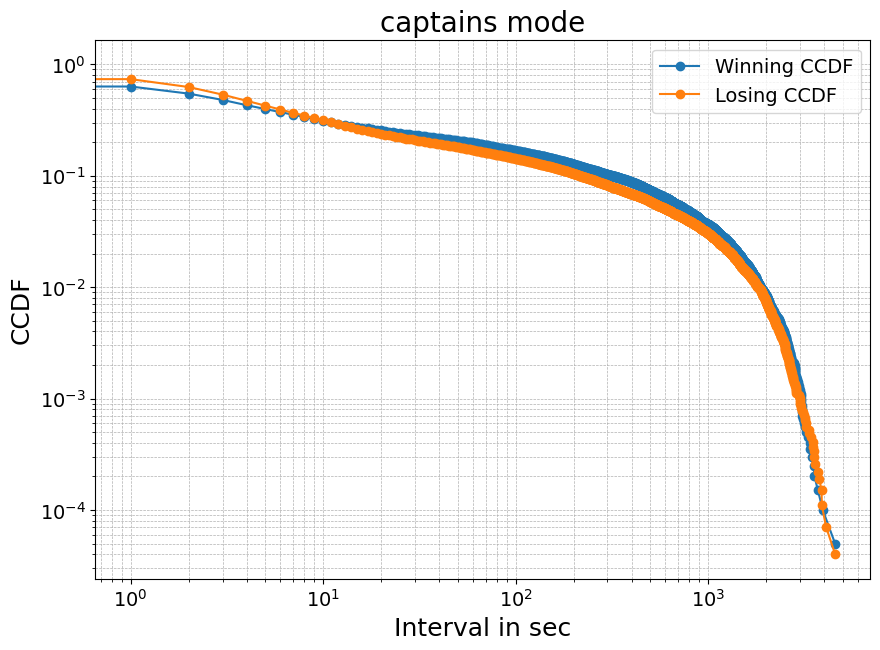

In [51]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Calculate CCDF for a given sample
def calculate_ccdf(sample):
    counts = Counter(sample) 
    sorted_values = np.array(sorted(counts.keys())) 
    frequencies = np.array([counts[val] for val in sorted_values])  
    cumulative = np.cumsum(frequencies[::-1])[::-1]  
    ccdf = cumulative / len(sample)  # Normalize 
    ccdf = np.round(ccdf, 5)
    ccdf[0] = 1
    return sorted_values, ccdf

# Compute CCDF for winning and losing samples
x1, ccdf1 = calculate_ccdf(winning_sample)
x2, ccdf2 = calculate_ccdf(losing_sample)

# Plotting
plt.figure(figsize=(10, 7))

plt.plot(x1, ccdf1, label='Winning CCDF', marker='o')
plt.plot(x2, ccdf2, label='Losing CCDF', marker='o')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Interval in sec', fontsize=18)
plt.ylabel('CCDF', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)
plt.title('captains mode', fontsize=20)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

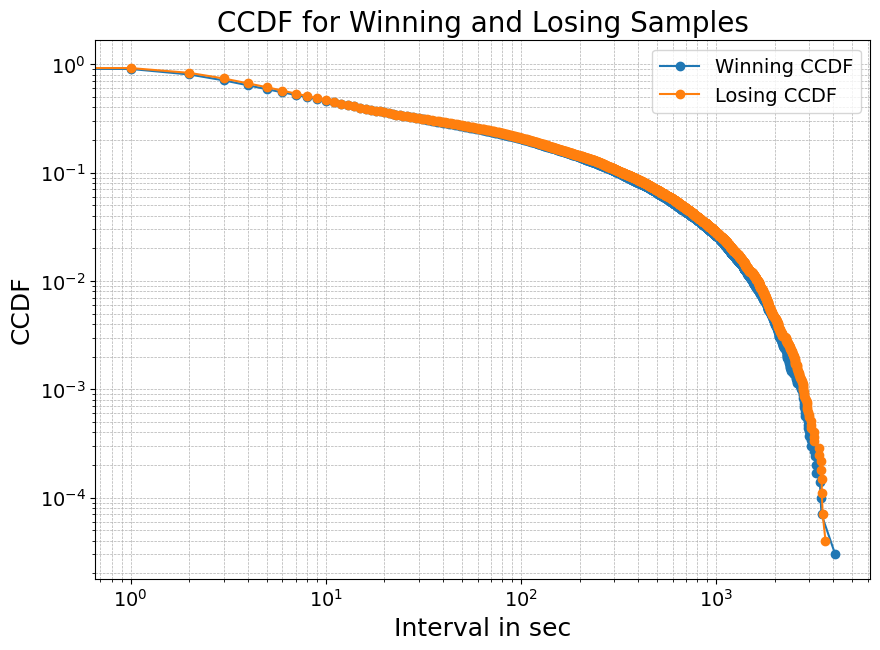

In [41]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Calculate CCDF for a given sample
def calculate_ccdf(sample):
    counts = Counter(sample) 
    sorted_values = np.array(sorted(counts.keys())) 
    frequencies = np.array([counts[val] for val in sorted_values])  
    cumulative = np.cumsum(frequencies[::-1])[::-1]  
    ccdf = cumulative / len(sample)  # Normalize 
    ccdf = np.round(ccdf, 5)
    ccdf[0] = 1
    return sorted_values, ccdf

# Compute CCDF for winning and losing samples
x1, ccdf1 = calculate_ccdf(winning_sample)
x2, ccdf2 = calculate_ccdf(losing_sample)

# Plotting
plt.figure(figsize=(10, 7))

plt.plot(x1, ccdf1, label='Winning CCDF', marker='o')
plt.plot(x2, ccdf2, label='Losing CCDF', marker='o')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Interval in sec', fontsize=18)
plt.ylabel('CCDF', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)
plt.title('CCDF for Winning and Losing Samples', fontsize=20)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [32]:
ccdf1

array([1.   , 0.632, 0.546, ..., 0.   , 0.   , 0.   ])

In [33]:
x1

array([   0,    1,    2, ..., 3722, 3943, 4568])

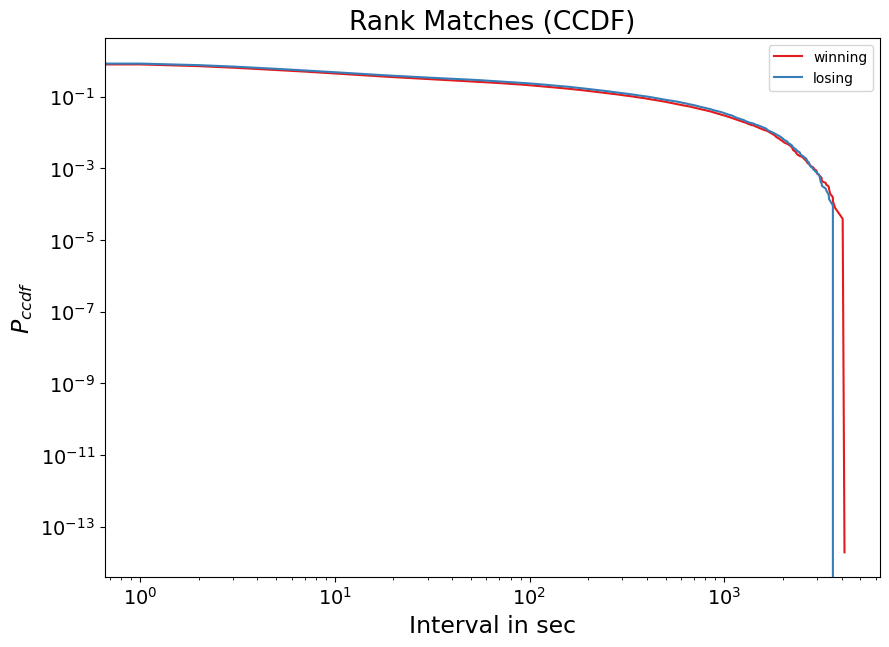

In [16]:
import numpy as np
plt.figure(figsize=(10,7))    
palette = sns.color_palette("Set1")

# Calculate CCDF for y1 and y2
ccdf_y1 = 1 - np.cumsum(all_pick['y1']) / np.sum(all_pick['y1'])
ccdf_y2 = 1 - np.cumsum(all_pick['y2']) / np.sum(all_pick['y2'])

plt.plot(all_pick['x1'], ccdf_y1, label='Won', color=palette[0])
plt.plot(all_pick['x2'], ccdf_y2, label='Lost', color=palette[1])

plt.xlabel('Interval in sec', fontsize=17)
plt.ylabel('$P_{ccdf}$', fontsize=17)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['winning', 'losing'])
plt.yscale('log')
plt.xscale('log')
plt.title('Rank Matches (CCDF)', fontsize=19)

# all_pick={'x1':x1,'y1':y1,'x2':x2,'y2':y2}
plt.savefig('allpick_ccdf.pdf')
plt.show()

In [27]:
ccdf1

array([1.00000000e+00, 6.32164414e-01, 5.46016860e-01, ...,
       1.49648326e-04, 9.97655510e-05, 4.98827755e-05])

In [9]:
import json
with open("rank_dict.json", "wb") as f:
    f.write(json.dumps(all_pick).encode("utf-8"))

NameError: name 'all_pick' is not defined

In [12]:
# with open('rank_dict.json') as f_in:
#     rank = json.load(f_in)
with open('allpick_dict.json') as f_in:
    all_pick = json.load(f_in)
with open('allrandom_dict.json') as f_in:
    allrandom = json.load(f_in)

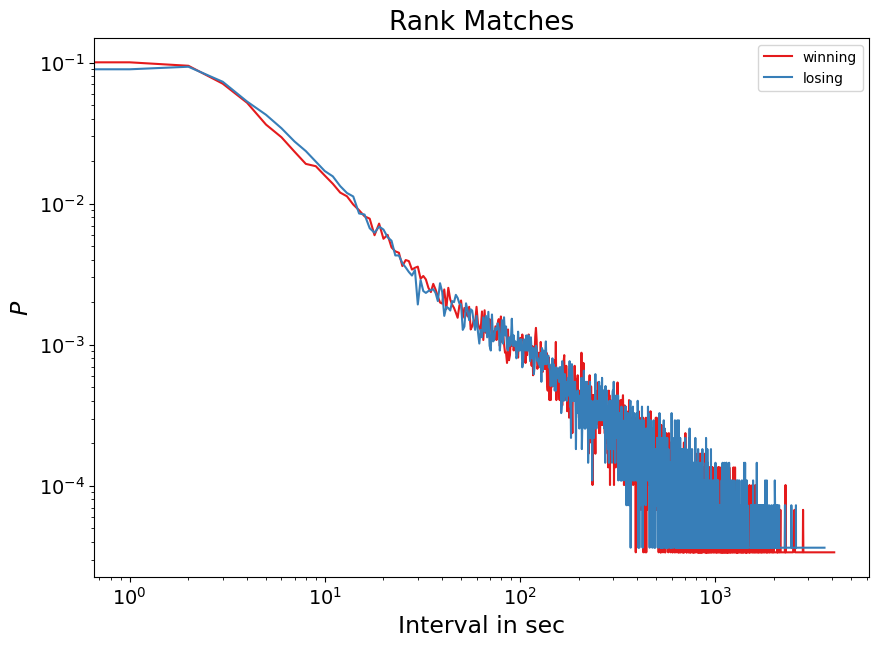

In [8]:
# from collections import Counter
# wining_dist = Counter(winning_sample)
# losing_dist = Counter(losing_sample)

# x1=[]
# y1=[]
# for i in sorted(wining_dist):   
#     x1.append(i)
#     y1.append(wining_dist[i]/len(winning_sample))
# x2=[]
# y2=[]
# for i in sorted(losing_sample):   
#     x2.append(i)
#     y2.append(losing_dist[i]/len(losing_sample))
import seaborn as sns
plt.figure(figsize=(10,7))    
palette = sns.color_palette("Set1")

plt.plot(rank['x1'],rank['y1'],label='Won',color=palette[0])
plt.plot(rank['x2'],rank['y2'],label='Lost',color=palette[1])
plt.xlabel('Interval in sec', fontsize=17)
plt.ylabel('$P$', fontsize=17)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['winning','losing'])
plt.yscale('log')
plt.xscale('log')
plt.title('Rank Matches', fontsize=19)

# all_pick={'x1':x1,'y1':y1,'x2':x2,'y2':y2}
#plt.savefig('rank_intervals.pdf')
plt.show()

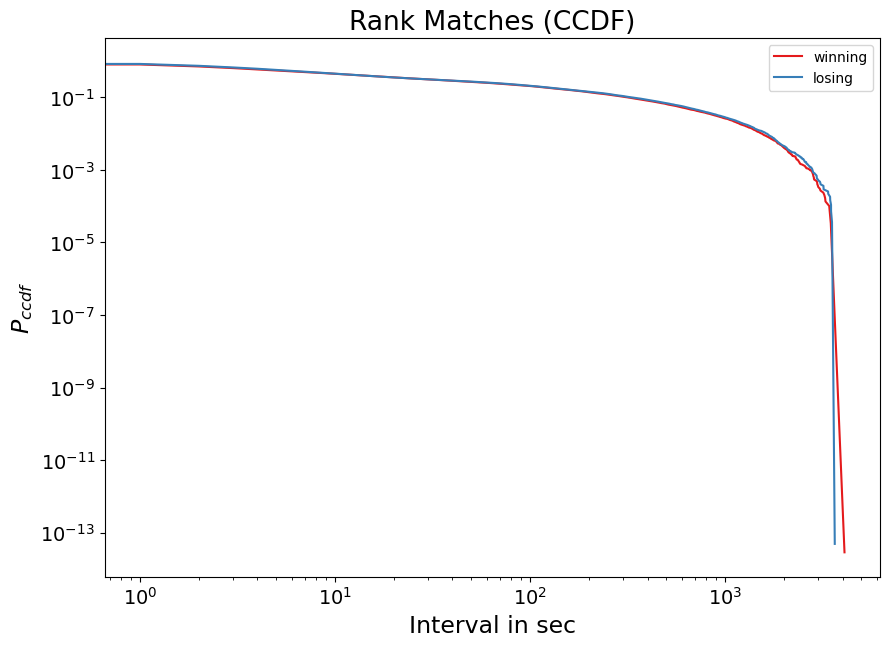

In [11]:
import numpy as np
plt.figure(figsize=(10,7))    
palette = sns.color_palette("Set1")

# Calculate CCDF for y1 and y2
ccdf_y1 = 1 - np.cumsum(rank['y1']) / np.sum(rank['y1'])
ccdf_y2 = 1 - np.cumsum(rank['y2']) / np.sum(rank['y2'])

plt.plot(rank['x1'], ccdf_y1, label='Won', color=palette[0])
plt.plot(rank['x2'], ccdf_y2, label='Lost', color=palette[1])

plt.xlabel('Interval in sec', fontsize=17)
plt.ylabel('$P_{ccdf}$', fontsize=17)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['winning', 'losing'])
plt.yscale('log')
plt.xscale('log')
plt.title('Rank Matches (CCDF)', fontsize=19)

# all_pick={'x1':x1,'y1':y1,'x2':x2,'y2':y2}
plt.savefig('rank_intervals_ccdf.pdf')
plt.show()

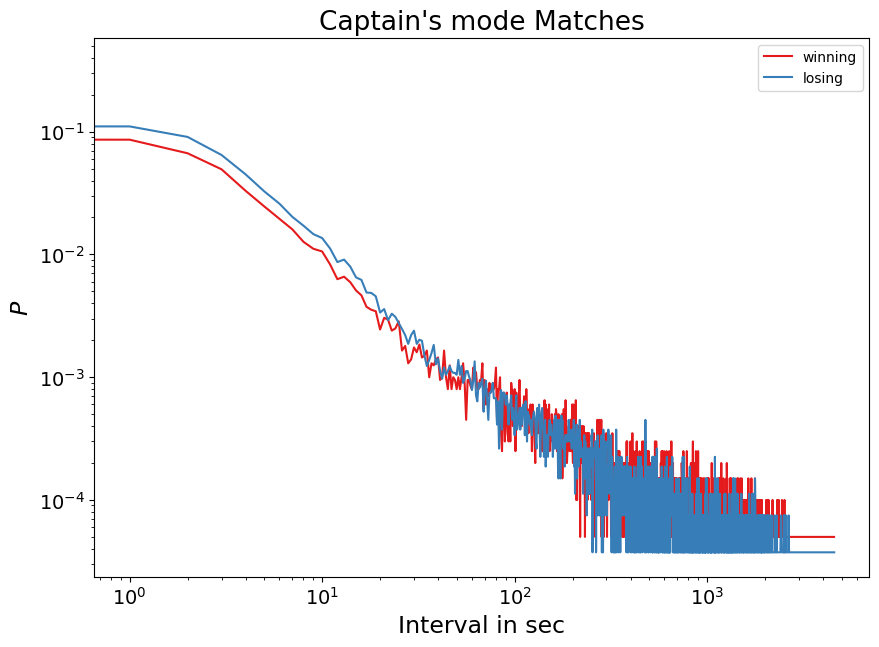

In [25]:
plt.figure(figsize=(10,7))    
palette = sns.color_palette("Set1")

plt.plot(all_pick['x1'],all_pick['y1'],label='Won',color=palette[0])
plt.plot(all_pick['x2'],all_pick['y2'],label='Lost',color=palette[1])
plt.xlabel('Interval in sec', fontsize=17)
plt.ylabel('$P$', fontsize=17)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['winning','losing'])
plt.yscale('log')
plt.xscale('log')
plt.title('Captain\'s mode Matches', fontsize=19)

# all_pick={'x1':x1,'y1':y1,'x2':x2,'y2':y2}
#plt.savefig('captain_intervals.pdf')
plt.show()

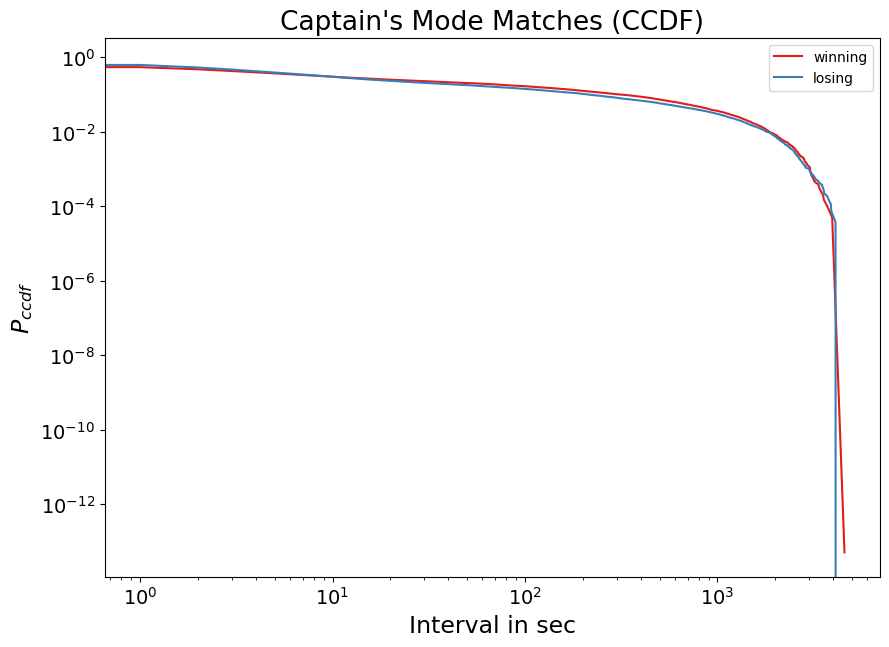

In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))    
palette = sns.color_palette("Set1")

# Calculate CCDF for y1 and y2
ccdf_y1 = 1 - np.cumsum(all_pick['y1']) / np.sum(all_pick['y1'])
ccdf_y2 = 1 - np.cumsum(all_pick['y2']) / np.sum(all_pick['y2'])

plt.plot(all_pick['x1'], ccdf_y1, label='Won', color=palette[0])
plt.plot(all_pick['x2'], ccdf_y2, label='Lost', color=palette[1])

plt.xlabel('Interval in sec', fontsize=17)
plt.ylabel('$P_{ccdf}$', fontsize=17)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['winning', 'losing'])
plt.yscale('log')
plt.xscale('log')
plt.title('Captain\'s Mode Matches (CCDF)', fontsize=19)

# Save the plot
plt.savefig('captain_intervals_ccdf.pdf')
plt.show()

In [3]:
all_pick['y1']

NameError: name 'all_pick' is not defined

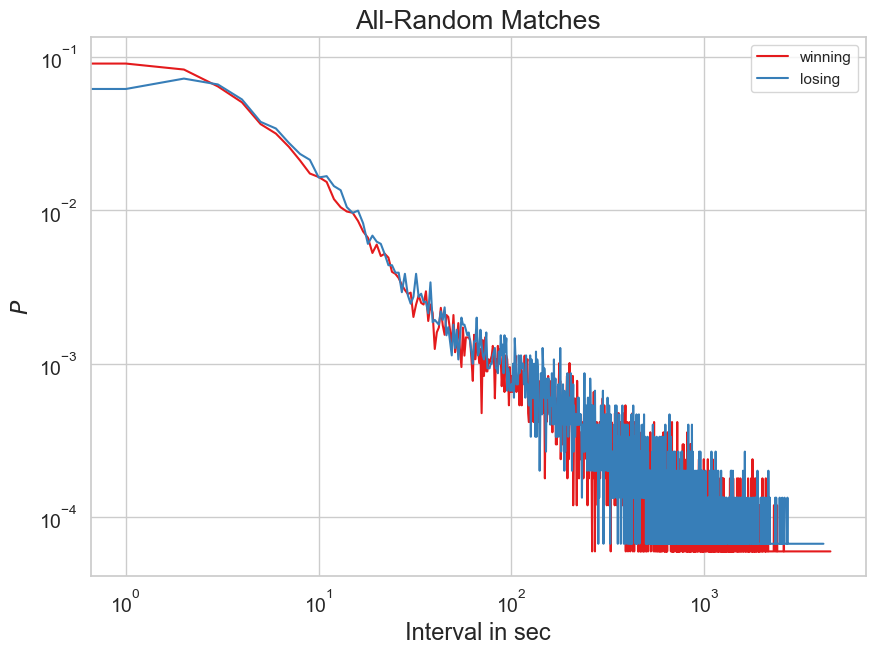

In [28]:
# from collections import Counter
# wining_dist = Counter(winning_sample)
# losing_dist = Counter(losing_sample)

# x1=[]
# y1=[]
# for i in sorted(wining_dist):   
#     x1.append(i)
#     y1.append(wining_dist[i]/len(winning_sample))
# x2=[]
# y2=[]
# for i in sorted(losing_sample):   
#     x2.append(i)
#     y2.append(losing_dist[i]/len(losing_sample))
plt.figure(figsize=(10,7))    
palette = sns.color_palette("Set1")

plt.plot(allrandom['x1'],allrandom['y1'],label='Won',color=palette[0])
plt.plot(allrandom['x2'],allrandom['y2'],label='Lost',color=palette[1])
plt.xlabel('Interval in sec', fontsize=17)
plt.ylabel('$P$', fontsize=17)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['winning','losing'])
plt.yscale('log')
plt.xscale('log')
plt.title('All-Random Matches', fontsize=19)

# all_pick={'x1':x1,'y1':y1,'x2':x2,'y2':y2}
plt.savefig('allrandom_intervals.pdf')
plt.show()

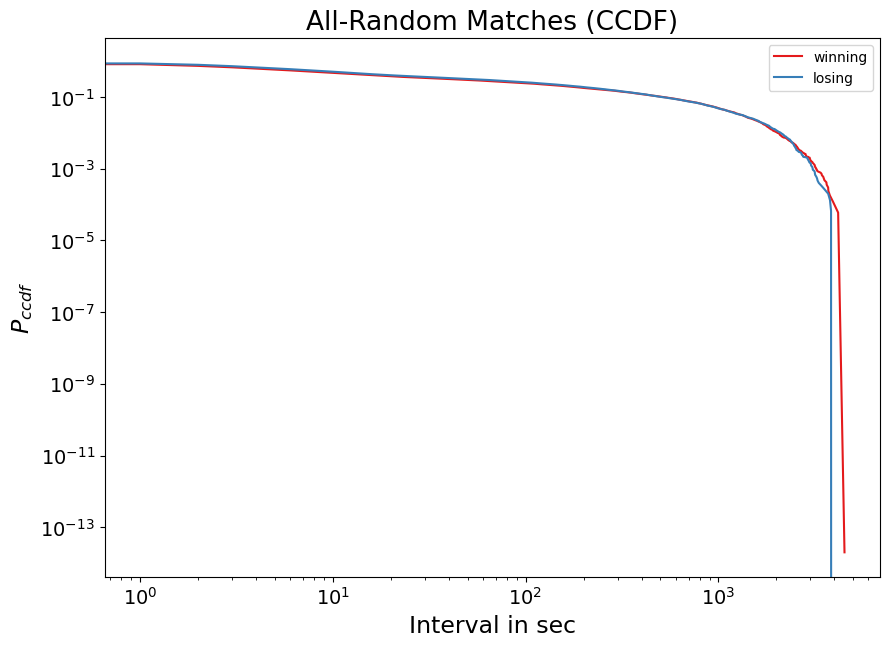

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))    
palette = sns.color_palette("Set1")

# Calculate CCDF for y1 and y2
ccdf_y1 = 1 - np.cumsum(allrandom['y1']) / np.sum(allrandom['y1'])
ccdf_y2 = 1 - np.cumsum(allrandom['y2']) / np.sum(allrandom['y2'])

plt.plot(allrandom['x1'], ccdf_y1, label='Won', color=palette[0])
plt.plot(allrandom['x2'], ccdf_y2, label='Lost', color=palette[1])

plt.xlabel('Interval in sec', fontsize=17)
plt.ylabel('$P_{ccdf}$', fontsize=17)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['winning', 'losing'])
plt.yscale('log')
plt.xscale('log')
plt.title('All-Random Matches (CCDF)', fontsize=19)

# Save the plot
plt.savefig('allrandom_intervals_ccdf.pdf')
plt.show()

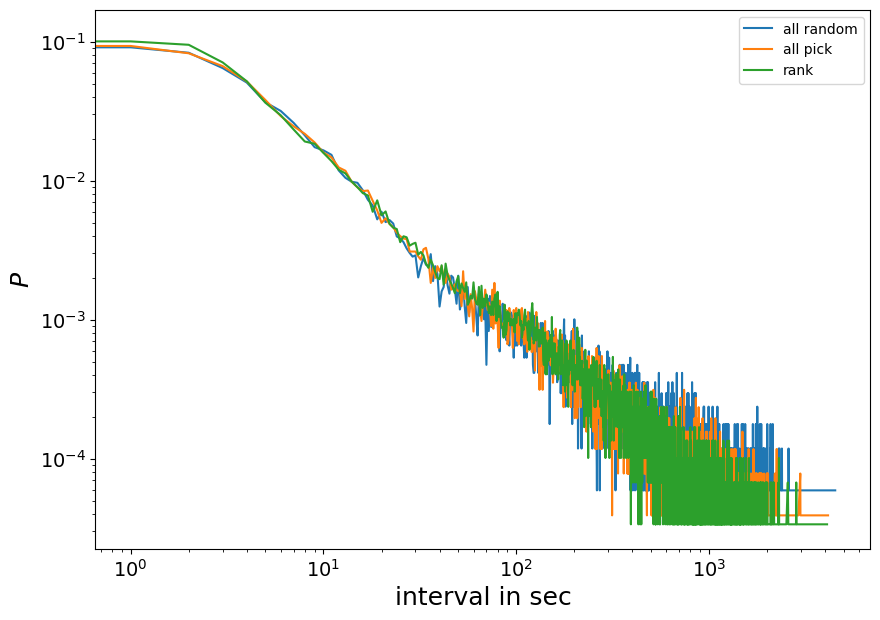

In [52]:
plt.figure(figsize=(10,7))    
plt.plot(allrandom['x1'],allrandom['y1'])
plt.plot(all_pick['x1'],all_pick['y1'])
plt.plot(rank['x1'],rank['y1'])

plt.xlabel('interval in sec', fontsize=18)
plt.ylabel('$P$', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['all random','all pick','rank'])
plt.yscale('log')
plt.xscale('log')
#plt.title('All pick')


plt.show()

Text(0, 0.5, 'P')

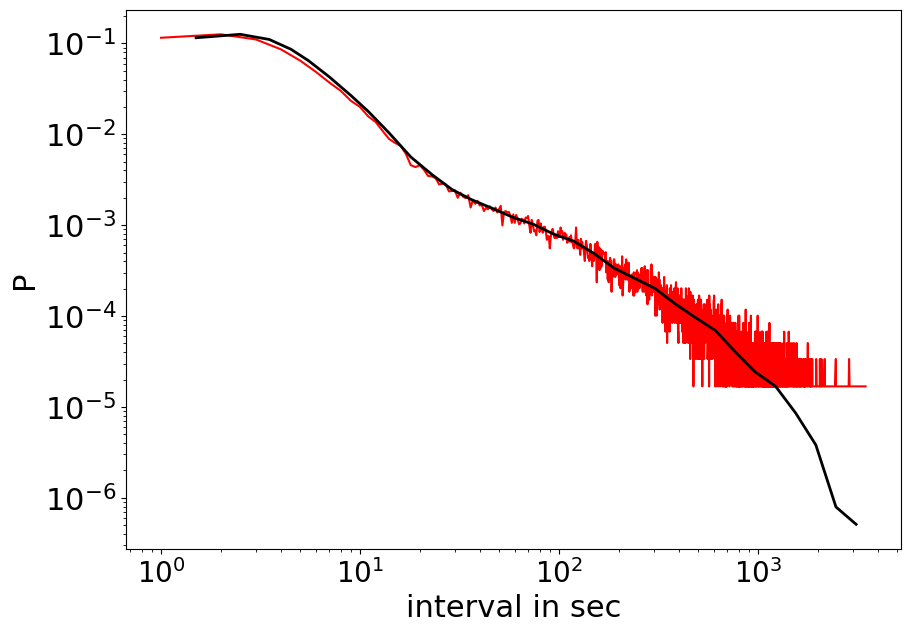

In [64]:
plt.figure(figsize=(10,7))
plt.yscale('log')
plt.xscale('log')

plt.plot(x,y,'r')

powerlaw.plot_pdf(adjusted_intervals, color='black', linewidth=2)

plt.xticks(fontsize=20)
plt.yticks(fontsize=22)

plt.xlabel('interval in sec', fontsize=22)
plt.ylabel('P', fontsize=22)

In [ ]:
x=[]
y=[]
for i in sorted(adjusted_intervals):   
    x.append(i)
    y.append(adjusted_intervals[i]/len(G))

plt.figure(figsize=(10,7))    
plt.plot(x,y)

plt.xlabel('degree $k$', fontsize=18)
plt.ylabel('$P(k)$', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.yscale('log')
plt.xscale('log')
plt.axis([1,1000,0.00001,0.2])
plt.show()

Calculating best minimal value for power law fit


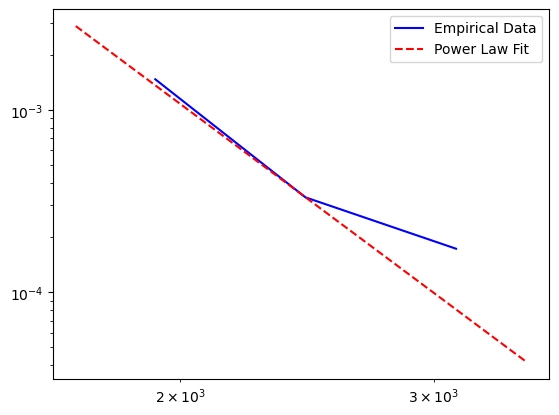

In [52]:
import powerlaw
fit = powerlaw.Fit(adjusted_intervals)
fig = fit.plot_pdf(color='b', label='Empirical Data')
fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig, label='Power Law Fit')
plt.legend()
plt.show()

Text(0, 0.5, '$P(k)$')

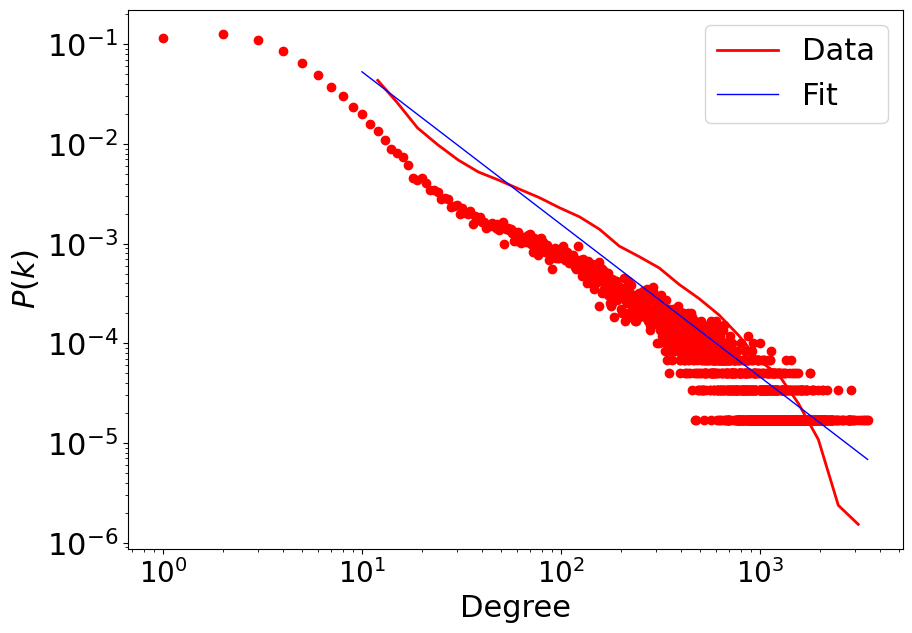

In [65]:
fig=plt.figure(figsize=(10,7))
fit_function_fixmin = powerlaw.Fit(adjusted_intervals, xmin=10)

plt.plot(x,y,'ro')

fig=powerlaw.plot_pdf([x for x in adjusted_intervals if x>10], color='r', linewidth=2, label='Data')

fit_function_fixmin.power_law.plot_pdf(ax=fig, color='b', linestyle='-', linewidth=1, label='Fit')

fig.legend(fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=22)
plt.xlabel('Degree', fontsize=22)
plt.ylabel('$P(k)$', fontsize=22)

In [27]:
from collections import Counter

dict(Counter(interval_sample))

{583: 4,
 19: 271,
 0: 6862,
 3: 5123,
 4: 3851,
 5: 2894,
 1: 7485,
 6: 2213,
 2: 6570,
 10: 936,
 32: 122,
 50: 97,
 180: 26,
 175: 15,
 7: 1792,
 11: 810,
 58: 78,
 8: 1389,
 24: 167,
 65: 68,
 123: 33,
 17: 272,
 174: 24,
 171: 30,
 61: 70,
 585: 4,
 516: 5,
 22: 204,
 14: 478,
 100: 45,
 95: 44,
 13: 529,
 46: 85,
 149: 24,
 15: 445,
 97: 43,
 711: 4,
 179: 15,
 243: 11,
 43: 89,
 20: 241,
 69: 75,
 109: 38,
 1304: 1,
 79: 50,
 379: 6,
 23: 196,
 37: 102,
 577: 3,
 125: 33,
 73: 60,
 286: 12,
 294: 12,
 247: 11,
 12: 647,
 1971: 1,
 18: 259,
 866: 2,
 387: 14,
 272: 12,
 350: 6,
 49: 89,
 111: 42,
 26: 167,
 38: 110,
 31: 135,
 9: 1189,
 52: 83,
 191: 16,
 138: 31,
 264: 18,
 324: 12,
 27: 140,
 223: 23,
 82: 49,
 40: 99,
 853: 3,
 144: 32,
 21: 207,
 76: 46,
 53: 85,
 39: 98,
 60: 77,
 482: 6,
 632: 2,
 99: 44,
 152: 34,
 84: 57,
 232: 12,
 135: 35,
 192: 18,
 33: 118,
 108: 47,
 67: 72,
 54: 82,
 669: 4,
 210: 16,
 657: 9,
 365: 13,
 201: 19,
 35: 93,
 448: 6,
 958: 1,
 78: 68,
